Name : Rugved Gadakh

Roll No : BE21IT016

PRN : 72280223E

Class : BE IT A

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
df =  pd.read_csv("D:\dl\creditcard.csv")

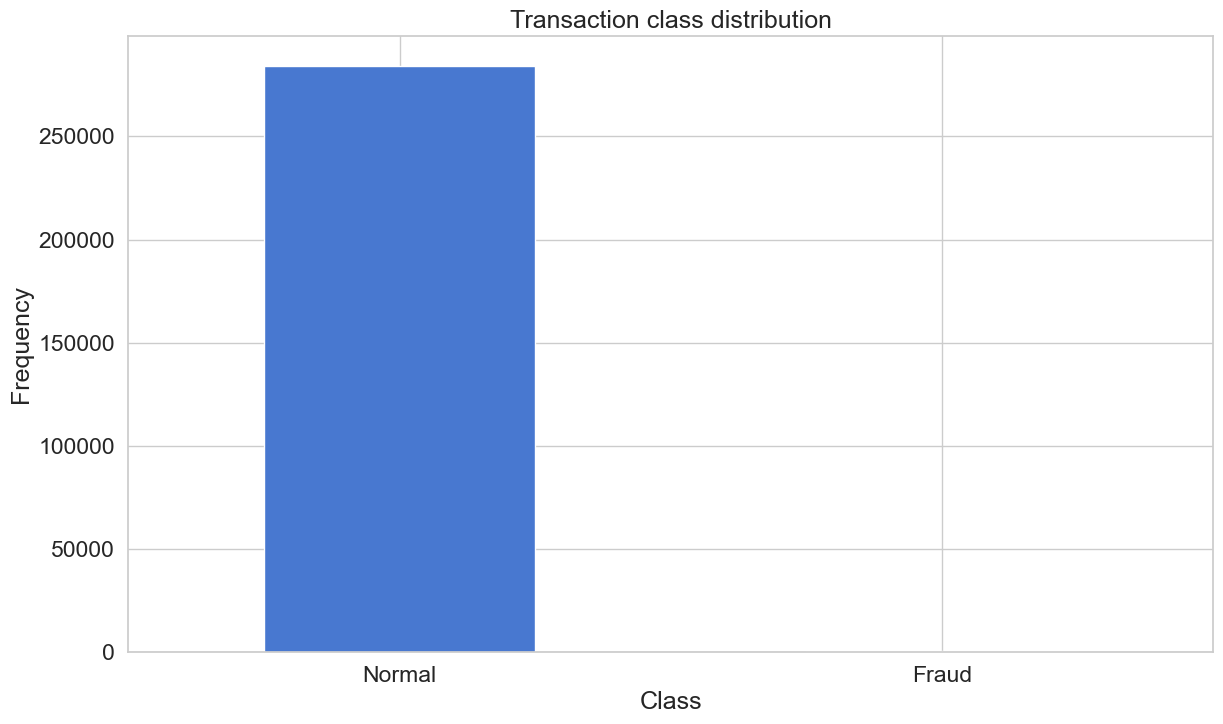

In [3]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [4]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))


In [5]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [6]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [7]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [8]:

nb_epoch = 100
batch_size = 32
early_stop = tf.keras.callbacks. EarlyStopping( monitor= 'val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', 
                                               restore_best_weights=True)

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, early_stop]).history

Epoch 1/100
7108/7108 [==============================] - 9s 1ms/step - loss: 0.8087 - accuracy: 0.5880 - val_loss: 0.7850 - val_accuracy: 0.6555
Epoch 2/100
  37/7108 [..............................] - ETA: 9s - loss: 0.9051 - accuracy: 0.6588 

C:\Users\rugve\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7108/7108 [==============================] - 8s 1ms/step - loss: 0.7411 - accuracy: 0.6792 - val_loss: 0.7638 - val_accuracy: 0.6974
Epoch 3/100
7108/7108 [==============================] - 10s 1ms/step - loss: 0.7280 - accuracy: 0.7002 - val_loss: 0.7559 - val_accuracy: 0.7098
Epoch 4/100
7108/7108 [==============================] - 11s 2ms/step - loss: 0.7221 - accuracy: 0.7120 - val_loss: 0.7544 - val_accuracy: 0.7071
Epoch 5/100
7108/7108 [==============================] - 9s 1ms/step - loss: 0.7191 - accuracy: 0.7177 - val_loss: 0.7516 - val_accuracy: 0.7148
Epoch 6/100
7108/7108 [==============================] - 8s 1ms/step - loss: 0.7173 - accuracy: 0.7192 - val_loss: 0.7510 - val_accuracy: 0.7167
Epoch 7/100
7108/7108 [==============================] - 8s 1ms/step - loss: 0.7159 - accuracy: 0.7196 - val_loss: 0.7486 - val_accuracy: 0.7214
Epoch 8/100
7108/7108 [==============================] - 8s 1ms/step - loss: 0.7150 - accuracy: 0.7190 - val_loss: 0.7490 - val_accuracy: 0.

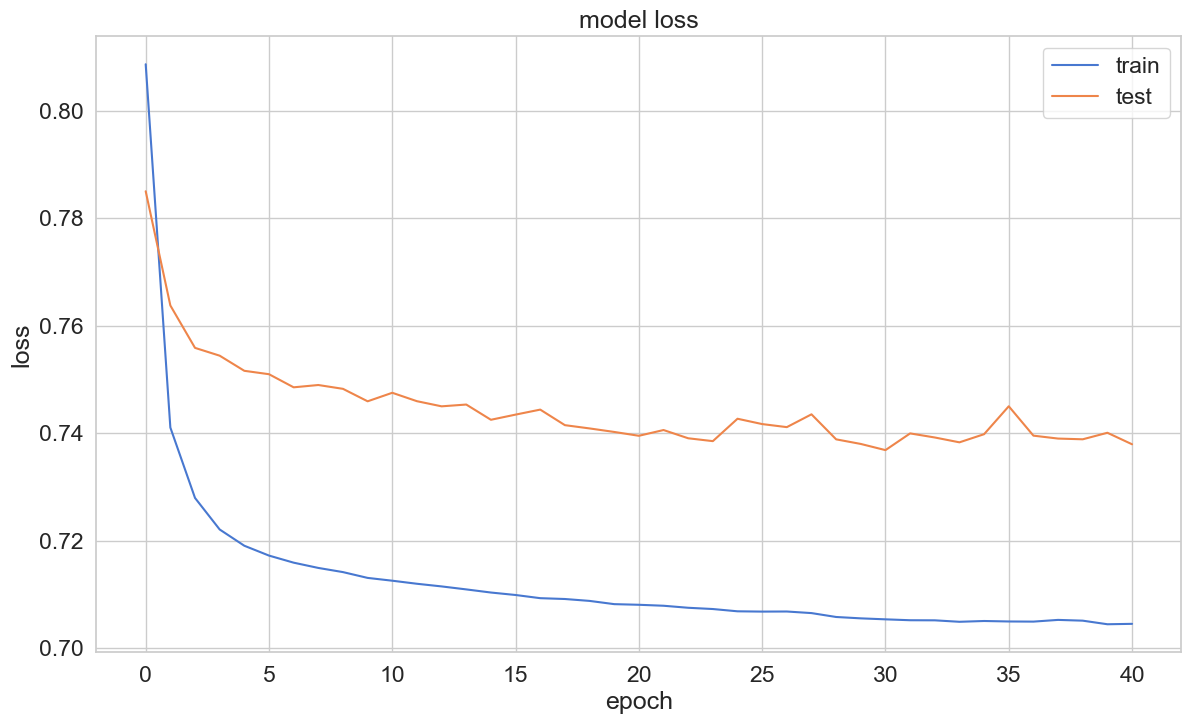

In [9]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [10]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 2s 868us/step


In [11]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [12]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.735992,0.001720
std,3.408955,0.041443
min,0.039457,0.000000
25%,0.241505,0.000000
50%,0.390068,0.000000
75%,0.637754,0.000000
max,258.994578,1.000000


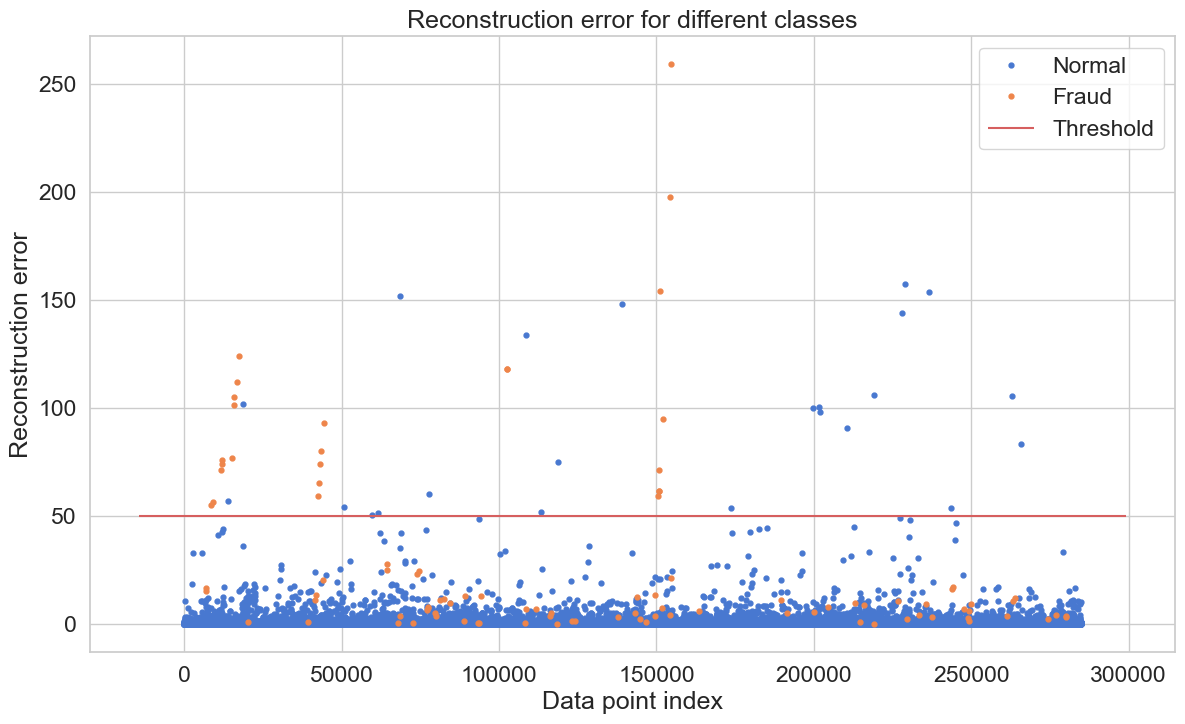

In [13]:
threshold = 50
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [14]:
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score

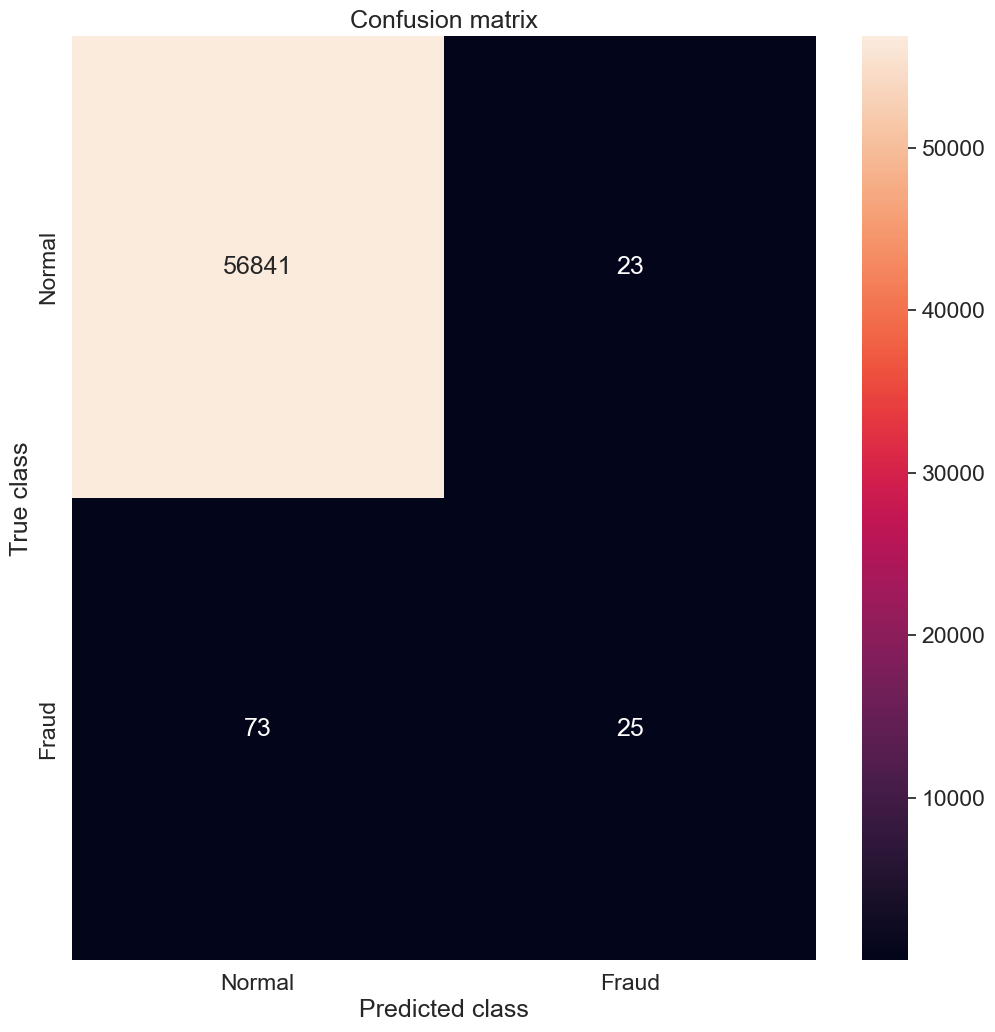

In [15]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [16]:
error_df['pred'] = y_pred

In [17]:
# print Accuracy, precision and recall print(" Accuracy:

print("Accuracy:",accuracy_score (error_df['true_class'],error_df['pred'])) 
print(" Recall:",recall_score(error_df['true_class'],error_df['pred']))
print(" Precision:",precision_score(error_df['true_class'],error_df['pred']))

Accuracy: 0.9983146659176293
 Recall: 0.25510204081632654
 Precision: 0.5208333333333334
